# Getting the embeddings

> This notebook gets the embeddings (or latent space) from a multivariate time series 
given by a encoder (e.g., autoencoder).

In [1]:
model_patch_size = 8
verbose          = 0
reset_kernel     = False

In [2]:
from dvats.all import *
from tsai.data.preparation import SlidingWindow
from fastcore.all import *
import wandb
wandb_api = wandb.Api()
from yaml import load, FullLoader
import dvats.utils as ut

/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(



Octave is ready <oct2py.core.Oct2Py object at 0x7f14275e5de0>

















In [3]:
import torch
torch.cuda.set_device(0)

## Config parameters
> Configuration parameters are obtained from 'config\03-embeddings.yaml'

### Get configuration artifact

In [4]:
config, job_type = get_artifact_config_embeddings(verbose = 0)

In [5]:
dvats.config.show_attrdict(config)

use_wandb: True
wandb_group: embeddings
wandb_entity: mi-santamaria
wandb_project: deepvats
enc_artifact: mi-santamaria/deepvats/mvp:latest
input_ar: None
cpu: False


### Show configuration artifact

In [6]:
for key, value in config.items():
    print(f"{key}: {value}")

use_wandb: True
wandb_group: embeddings
wandb_entity: mi-santamaria
wandb_project: deepvats
enc_artifact: mi-santamaria/deepvats/mvp:latest
input_ar: None
cpu: False


## Build W&B artifact

In [7]:
import os
path = os.path.expanduser("~/work/nbs_pipeline/")
name="03a_embeddings"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
print("runname: "+runname)

runname: 03a_embeddings


In [8]:
run = wandb.init(
    entity      = config.wandb_entity,
    project     = config.wandb_project if config.use_wandb else 'work-nbs', 
    group       = config.wandb_group,
    job_type    = job_type,
    mode        = 'online' if config.use_wandb else 'disabled',
    anonymous   = 'never'  if config.use_wandb else 'must',
    config      = config,
    resume      = 'allow',
    name        = runname
)

wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


## Get trained model artifact

### Build artifact selector
> Botch to use artifacts offline

In [9]:
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

### Get the model from W&B
> Restore the encoder model and its associated configuration

In [10]:
enc_artifact = artifacts_gettr(config.enc_artifact, type='learner')

In [11]:
# TODO: This only works when you run it two timeS! WTF?
try:
    enc_learner = enc_artifact.to_obj()
except:
    enc_learner = enc_artifact.to_obj()

wandb:   1 of 1 files downloaded.  


## Get dataset artifact from W&B
### Restore the dataset artifact used for training the encoder. 
> Even if we do not compute the dimensionality reduction over this dataset, we need to know the metadata of the encoder training set, to check that it matches with the dataset that we want to reduce.

In [12]:
enc_run            = enc_artifact.logged_by()
enc_artifact_train = artifacts_gettr(
                        enc_run.config['train_artifact'], 
                        type='dataset'
                    )
enc_artifact_train.name

'gtrends_khols-normalized_yearly:v0'

In [13]:
dvats.config.show_attrdict(enc_run.config)

r: 0.4
w: 17
MVP: {'r': 0.4, 'lm': 3, 'crit': None, 'sync': False, 'fname': 'encoder_MVP', 'dropout': 0.1, 'verbose': False, 'stateful': False, 'save_best': True, 'nan_to_num': 0, 'custom_mask': None, 'future_mask': True, 'weights_path': None, 'variable_mask': False, 'subsequence_mask': True}
alias: gtrends_khols-normalized_yearly
n_inp: 1
device: cuda
epochs: 200
frozen: False
mvp_ws: [12, 17]
stride: 1
Learner: {'lr': 0.001, 'wd': None, 'arch': 'tsai.models.InceptionTimePlus.InceptionTimePlus', 'moms': [0.95, 0.85, 0.95], 'path': '.', '_name': '<fastai.learner.Learner object at 0x7f811e636110>', 'metrics': None, 'opt_func': 'fastai.optimizer.Adam', 'splitter': 'tsai.models.utils.ts_splitter', 'train_bn': True, 'loss_func': {'axis': -1, '_name': {'axis': -1, '_name': 'FlattenedLoss of MSELoss()', 'is_2d': False, 'flatten': True, 'floatify': True}, 'is_2d': False, 'flatten': True, 'floatify': True}, 'model_dir': 'models', 'wd_bn_bias': False, 'default_cbs': True}
Recorder: {'add_time':

### Specify the dataset artifact that we want to get the embeddings from
> If no artifact is defined, the artifact to reduce will be the one used for validate the encoder.

In [14]:
enc_run.config['batch_size']

16

In [15]:
input_ar_name = ifnone(
    config.input_ar, 
    f'{enc_artifact_train.entity}/{enc_artifact_train.project}/{enc_artifact_train.name}'
)
wandb.config.update({'input_ar': input_ar_name}, allow_val_change=True)
input_ar = artifacts_gettr(input_ar_name)
input_ar.name

'gtrends_khols-normalized_yearly:v0'

In [16]:
df = input_ar.to_df()
df.head()

wandb:   1 of 1 files downloaded.  


,volume
2004-01-01,0.090912
2004-01-08,0.090912
2004-01-15,0.090912
2004-01-22,0.000000
2004-01-29,0.000000


In [17]:
df.shape

(440, 1)

In [18]:
enc_run.config['w'] = 54
enc_run.config['stride'] = 2

In [19]:
enc_input, _ = SlidingWindow(window_len=enc_run.config['w'], 
                             stride=enc_run.config['stride'], 
                             get_y=[])(df)
enc_input.shape

(194, 1, 54)

In [20]:
timer = ut.Time()
timer.start()

1737027479.1122394

In [21]:
config.enc_artifact

'mi-santamaria/deepvats/mvp:latest'

In [22]:
print(enc_learner)

In [23]:
enc_learn_class = str(enc_learner.__class__)[8:-2]

match enc_learn_class:
    case "momentfm.models.moment.MOMENTPipeline":
        get_embs_kwargs = {
            "cpu": config.cpu,
            "to_numpy": True,
            "verbose": 1
        }
    case "fastai.learner.Learner":
        get_embs_kwargs = {
            "stride": enc_run.config['stride'],
            "cpu": config.cpu,
            "to_numpy": True,
            "batch_size": enc_run.config['batch_size'],
            "average_seq_dim": True,
            "verbose": 1
        }
    case "uni2ts.model.moirai.module.MoiraiModule":
        get_embs_kwargs = {
            "cpu": config.cpu,
            "to_numpy": True,
            "batch_size": enc_run.config['batch_size'],
            "average_seq_dim": True,
            "verbose": 1,
            "patch_size": 8, #Modificar en config (añadir en base.yml & modificar lectura a "si existe, añadir"),
            "size": "small", #Modificar en config (añadir en base.yml & modificar lectura a "si existe, añadir"),
            "time": True
        }
    case _:
        print(f"Model embeddings implementation is not yet implemented for {enc_learn_class}.")

In [24]:
enc_learn_class

'fastai.learner.Learner'

In [25]:
enc_learn_class = str(enc_learner.__class__)[8:-2]
enc_learn_class

'fastai.learner.Learner'

In [26]:
match enc_learn_class:
    case "momentfm.models.moment.MOMENTPipeline":
        get_embs_kwargs = {
            "batch_size": enc_input.shape[0],
            "cpu"       : config.cpu,
            "to_numpy"  : True,
            "verbose"   : 1,
            "padd_step" : 10
        }
    case "fastai.learner.Learner":
        get_embs_kwargs = {
            "stride"         : 1,
            "cpu"            : config.cpu,
            "to_numpy"       : True,
            "batch_size"     : enc_run.config['batch_size'],
            "average_seq_dim": True,
            "verbose"        : 4
        }
    case "uni2ts.model.moirai.module.MoiraiModule":
        get_embs_kwargs = {
            "cpu"            : config.cpu,
            "to_numpy"       : True,
            "batch_size"     : enc_run.config['batch_size'],
            "average_seq_dim": True,
            "verbose"        : 2,
            "patch_size"     : model_patch_size, #Modificar en config (añadir en base.yml & modificar lectura a "si existe, añadir"),
            "time"           : True
        }
    case _:
        print(f"Model embeddings implementation is not yet implemented for {enc_learn_class}.")
print(f"Enc learn class {enc_learn_class}\nkwargs: {get_embs_kwargs}")

Enc learn class fastai.learner.Learner
kwargs: {'stride': 1, 'cpu': False, 'to_numpy': True, 'batch_size': 16, 'average_seq_dim': True, 'verbose': 4}


In [27]:
enc_run.config

{'r': 0.4,
 'w': 54,
 'MVP': {'r': 0.4,
  'lm': 3,
  'crit': None,
  'sync': False,
  'fname': 'encoder_MVP',
  'dropout': 0.1,
  'verbose': False,
  'stateful': False,
  'save_best': True,
  'nan_to_num': 0,
  'custom_mask': None,
  'future_mask': True,
  'weights_path': None,
  'variable_mask': False,
  'subsequence_mask': True},
 'alias': 'gtrends_khols-normalized_yearly',
 'n_inp': 1,
 'device': 'cuda',
 'epochs': 200,
 'frozen': False,
 'mvp_ws': [12, 17],
 'stride': 2,
 'Learner': {'lr': 0.001,
  'wd': None,
  'arch': 'tsai.models.InceptionTimePlus.InceptionTimePlus',
  'moms': [0.95, 0.85, 0.95],
  'path': '.',
  '_name': '<fastai.learner.Learner object at 0x7f811e636110>',
  'metrics': None,
  'opt_func': 'fastai.optimizer.Adam',
  'splitter': 'tsai.models.utils.ts_splitter',
  'train_bn': True,
  'loss_func': {'axis': -1,
   '_name': {'axis': -1,
    '_name': 'FlattenedLoss of MSELoss()',
    'is_2d': False,
    'flatten': True,
    'floatify': True},
   'is_2d': False,
   'fl

In [28]:
enc_learner.__class__

fastai.learner.Learner

In [29]:
import warnings
import math
from dvats.memory import *
import dvats.utils as ut
from dvats.config import show_attrdict
from copy import deepcopy
## -- Classes & types
from dataclasses import dataclass, field
from typing import List, Optional, Tuple, Callable, Union, Any

# Fastai
#| export
from fastai.learner import Learner
from tsai.data.core import TSDataLoaders
# Moirai
import uni2ts.model.moirai.module as moirai
import uni2ts.model.moirai.forecast as moirai_forecast

In [30]:
import pandas as pd
import numpy as np
from fastcore.all import *
from tsai.callback.MVP import *
from tsai.imports import *
from tsai.models.InceptionTimePlus import InceptionTimePlus
from tsai.models.explainability import get_acts_and_grads
from tsai.models.layers import *
from tsai.data.validation import combine_split_data
from tsai.basics import *
from fastai.callback.hook import hook_outputs
from momentfm import MOMENTPipeline
from gluonts.dataset.pandas import PandasDataset
from tsai.data.validation import TimeSplitter
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
from fastai.callback.tracker import SaveModelCallback
import time
import einops
import traceback

In [31]:
from fastai.losses import MSELossFlat

In [32]:
from fastai.callback.core import Callback

In [33]:
class MVPMetricsRecorder(MVP):
    """
    Callback to record custom metric values during validation.
    Stores the results in a shared dictionary for later use.
    """
    def __init__(self, metrics_dict, eval_results_pre, eval_results_post, validate_before_train, validate_after_train, **args):
        self.metrics_dict          = metrics_dict
        self.eval_results_pre      = eval_results_pre
        self.eval_results_post     = eval_results_post
        self.validate_before_train = validate_before_train
        self.validate_after_train  = validate_after_train
        self.current_results       = None
        super().__init__(**args)
    
    def red_print(self, mssg, header = ""):
            print(f"\033[91m{header} | {mssg} \033[0m")

    def before_fit(self): 
        try:
            if self.validate_before_train:
                self.red_print("--> Before fit | Exec validate", "MVP")
                print("Assign current result")
                self.current_results = self.eval_results_pre #Assigns pointer
                self.red_print("Before fit | Exec validate -->", "MVP")
        except Exception as e:
            print(f"Error in MVPMetricsRecorder | Before Fit: {e}")
            raise
        super().before_fit()
    
    def after_fit(self): 
        try:
            if self.validate_after_train:
                self.red_print("--> After fit | Exec validate", "MVP")
                self.current_results = self.eval_results_post #Assigns pointer
                self.red_print("After fit | Exec validate -->", "MVP")
        except Exception as e:
            print(f"Error in MVPMetricsRecorder | After Fit: {e}")
            raise
        super().after_fit()
        
    def before_validate(self):
        print("Before validate")
        try:
            self.red_print("Before validate: Reset dictionary", "MVP")
            # Reset the metric dictionary for the current validation pass
            for metric_name, _ in self.current_results.items():
                self.current_results[metric_name] = []
        except Exception as e:
            print(f"Error in MVPMetricsRecorder | Before Validate: {e}")
            raise
            
    def after_pred(self):
        try:
            self.red_print("after_pred | Calculate and store each metric for the current batch", "MVP")
            # Calculate and store each metric for the current batch
            preds = self.learn.pred
            targets = self.learn.y
            for metric_name, metric_func in self.metrics_dict.items():
                try:
                    batch_value = metric_func(
                        preds[self.mask], 
                        targets[self.mask]
                    ).item()
                    self.red_print(f"Batch value: {batch_value}", "MVP")
                except Exception as e:
                    self.red_print(f"Error computing {metric_name} ({metric_func.__name__}): {e}", "MVP")
        except Exception as e:
            print(f"Error in MVPMetricsRecorder | After pred: {e}")
            raise
            self.current_results[metric_name] += [ batch_value ]
    
    def after_validate(self):
        try:
            # Aggregate results for all batches in validation
            for metric_name, values in self.metrics_dict.items():
                self.current_results[metric_name] = sum(values) / len(values)
            self.red_print(f"MVP | Validation results: {self.current_results}")
        except Exception as e:
            print(f"Error in MVPMetricsRecorder | After validate: {e}")
            raise


In [34]:
#| export
@dataclass
class LRScheduler:
    lr              : float = None
    flag            : bool  = None
    name            : str   = None
    num_warmup_steps: int   = None
    scheduler               = None

    def __post_init__(self):
        self.lr                 = self._check_lr(self.lr, 1e-5)
        self.flag               = self._check_flag(self.flag, False)
        self.name               = self._check_name(self.name, "OneCycleR")
        self.num_warmup_steps   = self._check_steps(self.num_warmup_steps, 0)

    # Validation methods
    def _check_lr(self, value, default):
        if not isinstance(value, (float, int)) or not math.isfinite(value) or value <= 0:
            warnings.warn(f"Invalid learning rate 'lr' ({value}). Using default: {default}")
            return default
        return float(value)

    def _check_flag(self, value, default):
        if not isinstance(value, bool):
            warnings.warn(f"Invalid type for 'flag' ({type(value)}). Using default: {default}")
            return default
        return value

    def _check_name(self, value, default):
        if not isinstance(value, str):
            warnings.warn(f"Invalid type for 'name' ({type(value)}). Using default: {default}")
            return default
        return value

    def _check_steps(self, value, default):
        if not isinstance(value, int) or value < 0:
            warnings.warn(f"Invalid type or negative value for 'num_warmup_steps' ({value}). Using default: {default}")
            return default
        return value

In [35]:
?? enc.model.fit_one_cycle

Object ` enc.model.fit_one_cycle` not found.


In [36]:
def fine_tune_mvp_single_(
    self            : Encoder,
    eval_pre        : bool  = False,
    eval_post       : bool  = False,
    shot            : bool  = False,
    show_plot       : bool  = False,
    sample_id       : int   = 0    
):
    self.show_plot = self.show_plot if show_plot is None else show_plot
    t_shot = 0
    t_eval_1 = 0
    t_eval_2 = 0
    losses = [],
    metrics = [ MSELossFlat, RMSELossFlat, MAELossFlat, SMAPELossFlat ]
    metrics_dict = get_metrics_dict(metrics, ["mse", "rmse", "mae", "smape"])
    eval_results_pre = {key: 0.0 for key in metrics_dict.keys()}
    eval_results_post = {key: 0.0 for key in metrics_dict.keys()}
    
    if self.time_flag : timer = ut.Time(mssg = self.mssg)
    self.mssg.initial("fine_tune_mvp_single_")   
    X = self.get_splits_(sample_id)
    self.mssg.print("About to set callbacks", func_name = ut.funcname())
    
    cbs = L(CustomWandbCallback(log_preds=False)) if self.use_wandb else L()
    
    self.mssg.print("About to set batch tfms")
    tfms = [ToFloat(), None]
    batch_tfms = [
        TSStandardize(
            by_sample       = self.norm_by_sample, 
            use_single_batch= self.norm_use_single_batch
        )
    ]
    dls = get_ts_dls(X, splits = self.splits, tfms = tfms, bs = self.input.batch_size, batch_tfms = batch_tfms)

    self.mssg.print(f"Metrics: {metrics}")
    if self.show_plot: 
        self.mssg.print("Show plot")
        display(dls.show_at(0))
        sgc = ShowGraphCallback2()
        self.model = ts_learner(
            dls, 
            InceptionTimePlus,
            cbs = cbs + sgc +MVP(
                r           = self.optim.lr if isinstance(self.optim.lr, float) else self.optim.lr.lr,
                window_size = X.shape[2]-1,
                future_mask = self.mask_future,
                target_dir  = './models',
                sync        = self.mask_sync,
                stateful    = self.mask_stateful,
                fname       = f'encoder_MVP',
            ),
            y_range = [X.min(), X.max()]#,
            #metrics = metrics
        )
    else:
        self.mssg.print("Don't show plot")
        self.model = ts_learner(
            dls, 
            InceptionTimePlus,
            cbs = cbs + mvp(
                r           = self.optim.lr if ( isinstance(self.optim.lr, float) or isinstance(self.optim.lr, int)) else self.optim.lr.lr,
                window_size = X.shape[2]-1,
                future_mask = self.mask_future,
                target_dir  = './models',
                sync        = self.mask_sync,
                stateful    = self.mask_stateful,
                fname       = f'encoder_MVP',
            ) + [ custom_opt_cb ],
            y_range = [X.min(), X.max()]#,
            #metrics = metrics
        )
        self.mssg.print(f"Model Class {self.model.__class__} | Type: {type(self.model)}")

    device = "cpu" if self.cpu else torch.cuda.current_device()
    self.model.to(device)
    self.mssg.print(f"Model Class {self.model.__class__} | Type: {type(self.model)}")
    
    # Eval - pre 
    if eval_pre:
        if self.time_flag: timer.start()
        self.mssg.print(f"Eval Pre | wlen {X.shape[2]} | Model: {self.model.__class__} | {type(self.model)} ")
        self.mssg.print(f"Model metrics: {self.model.metrics}")
        self.model.eval()
        #self.mssg.print(f"Model metrics after eval: {self.model.metrics}")
        self.mssg.print(f"metrics: {self.metrics}")
        results = validate_with_metrics(self.model, self.metrics)
        #self.model.validate()
        #self.mssg.print(f"Model metrics after validate: {self.model.metrics}")
        self.mssg.print(f"results~{len(results)}")
        eval_results_pre = validate_with_metrics_format_results(results = results, metrics = self.metrics, metrics_names = self.metrics_names)
        self.mssg.print(f"Eval results pre with custom metrics: {eval_results_pre}")
        if self.time_flag:
            timer.end()
            t_eval_1 = timer.duration()
            timer.show(verbose = self.mssg.verbose)
    # Train 
    if shot:
        if self.time_flag: timer.start()
        self.model.train()
        self.mssg.print(f"Training the model | window size {X.shape[2]} | X ~ {X.shape}")
        self.fit_fastai(dls, show_plot = show_plot)
        losses = self.model.recorder.losses
        if self.time_flag:
            timer.end()
            t_shot= timer.duration()
            timer.show(verbose = self.mssg.verbose)

    # Eval - post
    if eval_post:
        if self.time_flag: timer.start()
        self.mssg.print(f"Eval Pre | wlen {X.shape[2]}")
        self.model.eval()
        results = validate_with_metrics(self.model, self.metrics)
        self.mssg.print(f"Format results | results~{len(results)}")
        eval_results_post = validate_with_metrics_format_results(
            results = results, metrics = self.metrics, metrics_names = self.metrics_names)
        #self.model.validate()
        self.mssg.print(f"Eval results post with custom metrics: {eval_results_post}")
        if self.time_flag:
            timer.end()
            t_eval_2 = timer.duration()
            timer.show(verbose = self.mssg.verbose)
    self.mssg.final()
    return losses, eval_results_pre, eval_results_post, t_shot, t_eval_1, t_eval_2, self.model
Encoder.fine_tune_mvp_single_ = fine_tune_mvp_single_

In [37]:
#| export
def fine_tune_mvp_(
    self                    : Encoder,
    eval_pre                : bool  = True,
    eval_post               : bool  = True,
    shot                    : bool  = False,
    time_flag               : bool  = None,
    use_wandb               : bool  = None,
    analysis_mode           : str   = None,
    norm_by_sample          : bool  = None,
    norm_use_single_batch   : bool  = None,
    show_plot               : bool  = None
):
    self.mssg.initial_("fine_tune_mvp_")
    self.time_flag      = self.time_flag if time_flag is None else time_flag
    self.use_wandb      = self.use_wandb if use_wandb is None else use_wandb
    self.analysis_mode  = self.analysis_mode if analysis_mode is None else analysis_mode
    self.norm_by_sample = self.norm_by_sample if norm_by_sample is None else norm_by_sample
    self.norm_use_single_batch = self.norm_use_single_batch if norm_use_single_batch is None else norm_use_single_batch
    # Return values
    lossess             = []
    eval_results_pre    = {} # Only 1 (before fine-tune)
    eval_results_post   = [] # One per window size (after training)
    t_shots             = []
    t_shot              = 0
    t_evals             = []
    t_eval              = 0

    if self.input.size is None:
        self.mssg.print(f"Windows: {len(self.input._data)}")
        raise ValueError(f"Invalid number of windows: {self.input.size}")
    self.mssg.print(f"Processing {self.input.size} datasets: {self.input.shapes}")
    # Build optimizer
    if self.optim.optimizer is None: 
        self.mssg.print(f"Setting up optimizer as Adam")
        lr = self.optim.lr
        if (not isinstance(self.optim.lr, float)): 
            lr = self.optim.lr.lr,
       
        self.optim.optimizer = Adam(
            self.model.parameters(),
            lr = lr,
            mom = 0.0,
            sqr_mom = 0.99,
            eps = 1e-8,
            wd = 0.01,
            decouple_wd = True
        )
    self.mssg.print(f"Optimizer: {self.optim.optimizer}")
    # Compute model for each window in the windowed dataset
    for i in range(self.input.size):
        self.mssg.print(f"Processing wlen {self.input.shape[2]}")
        ( 
            losses, eval_results_pre_, eval_results_post_, t_shot_, t_eval_1, t_eval_2, self.model
        ) =  self.fine_tune_mvp_single_(eval_pre, eval_post, shot, sample_id = i, show_plot = show_plot)
        lossess.append(losses)
        if (eval_pre): eval_results_pre = eval_results_pre_
        if (eval_post): eval_results_post.append(eval_results_post_)
        t_shots.append(t_shot_)
        if eval_pre: t_evals.append(t_eval_1)
        if eval_post: t_evals.append(t_eval_2)
        eval_pre = False
    t_shot = sum(t_shots)
    t_eval = sum(t_evals)
    self.mssg.final(ut.funcname())
    return lossess, eval_results_pre, eval_results_post, t_shots, t_shot, t_evals, t_eval, self.model

Encoder.fine_tune_mvp_ = fine_tune_mvp_ 

In [38]:
#| export
from tqdm.auto import tqdm
from transformers import get_scheduler
import evaluate
from torch.nn.modules.loss import _Loss
from tsai.data.preparation import SlidingWindow
from dvats.utils import find_dominant_window_sizes_list

In [39]:
#| export
def _get_optimizer(
    mssg                            : ut.Mssg,
    optim                           : EncoderOptimizer = None,
    criterion                       : _Loss         = torch.nn.MSELoss, 
    optimizer                                       = None, 
    lr                              : float         = 5e-5, #1e-4, 
    lr_scheduler_flag               : bool          = False, 
    lr_scheduler_name               : str           = "linear",
    lr_scheduler_num_warmup_steps   : int           = None
):
    print("--> Get optimizer")
    mssg.initial(ut.funcname())
    optim,_ = ut._check_value(optim, None, "optim", EncoderOptimizer, True)
    if optim is None:
        print("Optim is none")
        optim = EncoderOptimizer(
            criterion   = criterion,
            optimizer   = optimizer,
            lr          = LRScheduler (
                            lr              = lr,
                            flag            = lr_scheduler_flag,
                            name            = lr_scheduler_name,
                            num_warmup_steps= lr_scheduler_num_warmup_steps
            ),
        )
        print(optim)
    print("Get optimizer -->")
    mssg.final()
    return optim

## Get encoder

In [40]:
import dvats.encoder as encoder

In [41]:
from fastai.optimizer import Adam

In [42]:
enc = encoder._get_encoder(
    X                   = df,
    stride              = enc_run.config['stride'],
    n_windows           = None,
    n_windows_percent   = 50,
    validation_percent  = 0.2,
    training_percent    = 1,
    window_mask_percent = 0.75,
    window_sizes        = [17],
    n_window_sizes      = 3,
    window_sizes_offset = None,
    windows_min_distance = 5,
    full_dataset         = True,
    enc_input            = None,
    optim                = None,
    criterion            = None,
    optimizer            = Adam,
    lr                   = None,
    lr_scheduler_flag    = None,
    lr_scheduler_num_warmup_steps = None,
    verbose              = 0,
    print_to_path        = False,
    print_path           = "~/data/logs.txt",
    print_mode           = 'w',
    mssg                 = None,
    enc                  = None,
    num_epochs           = 10,
    enc_learn            = enc_learner,
    cpu                  = False,
    to_numpy             = False,
    mask_stateful        = False,
    mask_future          = False,
    mask_sync            = False
)
enc.mask_sync     = enc_run.config['mask_sync']
enc.mask_stateful = enc_run.config['mask_stateful']
enc.mask_future   = enc_run.config['mask_future']
enc.optim.lr      = enc_run.config['r']
enc.time_flag     = True
enc.show_plot     = True

[0] [ --> windowed_dataset ]
[0]  [ _get_enc_input ] X is a DataFrame, X~(440, 1) | window_sizes 1, n_window_sizes 3
[0]  [ _get_enc_input ] X is a DataFrame | Selecting Fourier's dominant frequences
[0] [ --> Find_dominant_window_sizes_list ]
[0]  [ Find_dominant_window_sizes_list ] X ~ (440, 1)
[0]  [ Find_dominant_window_sizes_list ] Grouping sizes
[0] [Find_dominant_window_sizes_list --> ]
[0]  [ windowed_dataset ] X is a DataFrame | Window sizes: 3
[0]  [ windowed_dataset ] Building the windows
[0]  [ windowed_dataset ] Number of windows: 3
[0] [windowed_dataset --> ]


## Compute fine-tune

In [43]:
enc.mssg.verbose = 5
enc.metrics = [MSELossFlat, RMSELossFlat, SMAPELossFlat, MAELossFlat]
enc.metrics_names = ["mse", "rmse", "smape", "mae"]
enc.optim = _get_optimizer(
    mssg = ut.Mssg(),
    lr = 0.05, 
    lr_scheduler_flag = True, 
    lr_scheduler_num_warmup_steps = 2)

--> Get optimizer
Optim is none
EncoderOptimizer(criterion=<class 'torch.nn.modules.loss.MSELoss'>, optimizer=None, lr=LRScheduler(lr=0.05, flag=True, name='linear', num_warmup_steps=2))
Get optimizer -->


[5] [ --> fine_tune_mvp_ ]
[5]  [ fine_tune_mvp_ ] Processing 3 datasets: [(212, 1, 17), (212, 1, 18), (215, 1, 12)]
[5]  [ fine_tune_mvp_ ] Setting up optimizer as Adam
[5]  [ fine_tune_mvp_ ] Optimizer: <fastai.optimizer.Optimizer object at 0x7f1557fc85e0>
[5]  [ fine_tune_mvp_ ] Processing wlen 17
[5] [ --> fine_tune_mvp_single_ ]
[5] [ --> get_splits_ ]
[5]  [ get_splits_ ] len(X)=212
[5]  [ get_splits_ ] Online analysis


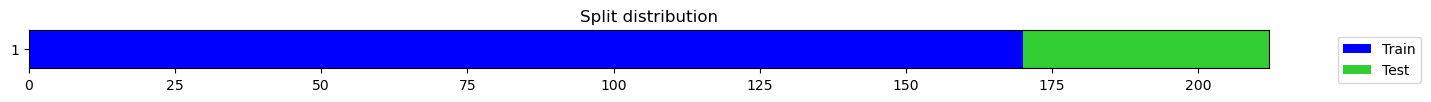

[5]  [ get_splits_ ] X~(212, 1, 17)
[5]  [ get_splits_ ] Train: 170 | Test 42
[5] [get_splits_ --> ]
[5]  [ fine_tune_mvp_single_ ] About to set callbacks
[5]  [ fine_tune_mvp_single_ ] About to set batch tfms
[5]  [ fine_tune_mvp_single_ ] Metrics: [<function MSELossFlat at 0x7f15e2a37250>, <function RMSELossFlat at 0x7f1427b39750>, <function L1LossFlat at 0x7f15e2a372e0>, <function SMAPELossFlat at 0x7f1427b39990>]
[5]  [ fine_tune_mvp_single_ ] Show plot


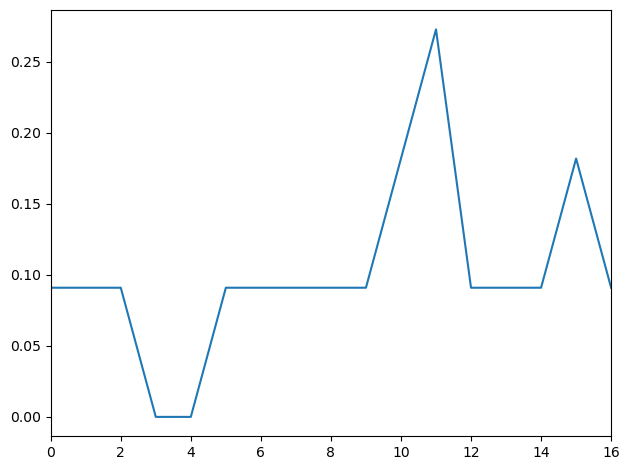

None

[5]  [ fine_tune_mvp_single_ ] Model Class <class 'fastai.learner.Learner'> | Type: <class 'fastai.learner.Learner'>
[5]  [ fine_tune_mvp_ ] Start timer
[5]  [ fine_tune_mvp_single_ ] Training the model | window size 17 | X ~ (212, 1, 17)
[5] [ --> fit_fastai ]


[5]  [ fit_fastai ] {'n_epoch': 10, 'lr_max': SuggestedLRs(valley=0.010964781977236271), 'pct_start': 0, 'cbs': [EarlyStoppingCallback]}


epoch,train_loss,valid_loss,time
0,1.322774,0.338413,00:00
1,1.096952,1.210207,00:00
2,0.926383,2.104485,00:00
3,0.986227,nan,00:00
4,0.913865,0.372710,00:00
5,1.143923,1.508256,00:00
6,1.158191,0.576997,00:00
7,1.196351,0.333020,00:00
8,1.130538,1.327151,00:00
9,1.164923,0.288633,00:00


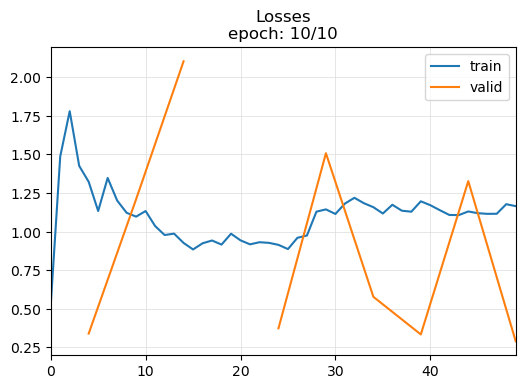

best epoch:   9  val_loss: 0.288633 - pretrained weights_path='models/encoder_MVP.pth'


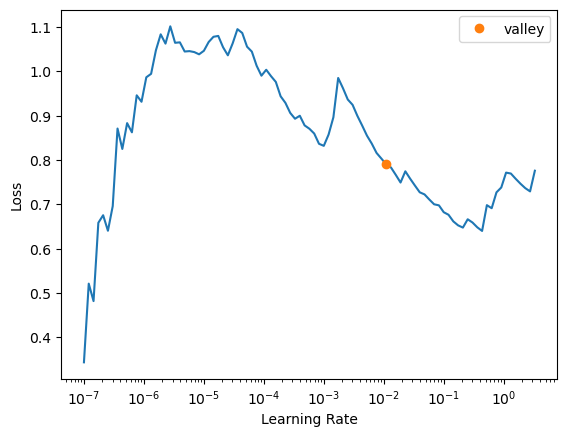

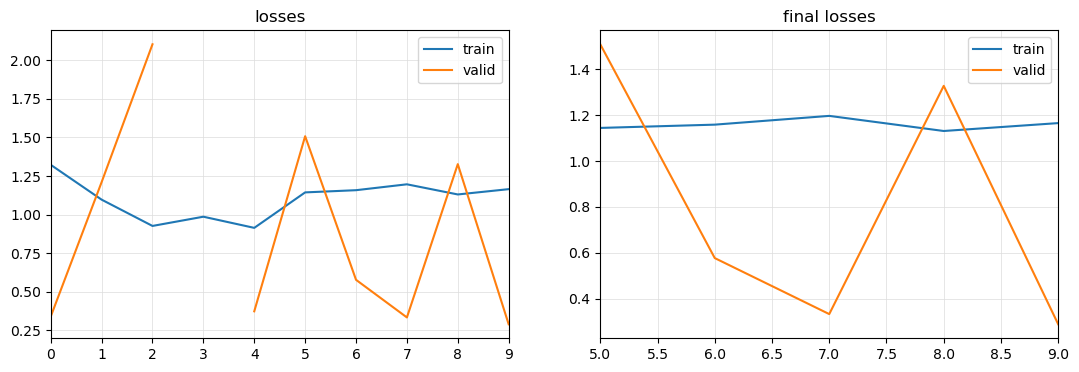

[5] [fit_fastai --> ]
[5]  [ fine_tune_mvp_ ] End timer -->
[5]  [ fine_tune_mvp_ ] Start: 1737027484.946489 | End: 1737027495.4729986 | Duration: 10.53 seconds
[5]  [ fine_tune_mvp_ ] Start timer
[5]  [ fit_fastai ] Eval Pre | wlen 17


not enough values to plot a chart


not enough values to plot a chart


not enough values to plot a chart


not enough values to plot a chart
[5]  [ fit_fastai ] Format results | results~2


IndexError: tuple index out of range

In [44]:
( 
    lossess, eval_results_pre, eval_results_post, 
    t_shots, t_shot, t_evals, t_eval, enc.model 
) = enc.fine_tune_(
    eval_pre              = False, 
    eval_post             = True, 
    shot                  = True, 
    time_flag             = True, 
    use_wandb             = enc_run.config['use_wandb'], 
    analysis_mode         = enc_run.config ['analysis_mode'], 
    norm_by_sample        = enc_run.config['norm_by_sample'], 
    norm_use_single_batch = enc_run.config['norm_use_single_batch'], 
    show_plot             = True
)

In [ ]:
print(eval_results_pre)
print(eval_results_post)

In [ ]:
metrics = [torch.nn.functional.mse_loss, rmse, mae, smape]
enc.model.metrics = metrics
enc.model.metrics

In [ ]:
enc.model.validate()

In [ ]:
enc.model.metrics

In [ ]:
#| export
if verbose > 0: print("Execution ended")
from dvats.imports import beep
beep(1)
beep(1)
beep(1)
beep(1)
beep(1)

In [ ]:
#| hide
if reset_kernel:
    import os
    os._exit(00)